In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lasio
import os
import glob
from dtaidistance import dtw
from dtaidistance import dtw_visualisation as dtwvis
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from fastdtw import fastdtw
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from geopy.distance import geodesic
import networkx as nx
import scipy.interpolate
import time

In [4]:
# directory on personal computer
ruta = 'C:/Users/User/Desktop/Pan American Energy/reference scripts/initial'
os.chdir(ruta)

ruta_logs = ruta + "/Perfiles_3"
las_files = glob.glob(os.path.join(ruta_logs, '*.las'))

logs = {}

# Function to calculate geodesic distance between two points
def calculate_distance(lat1, lon1, lat2, lon2):
    return geodesic((lat1, lon1), (lat2, lon2)).meters

# Create a directed graph
G = nx.DiGraph()

# Set the separation distance between nodes
separation_distance = 2

# Reference latitude and longitude (you may want to set this based on your specific location)
reference_latitude = 0
reference_longitude = 0

# Create nodes in a grid layout and connect nodes within 200 meters
for i, las_file in enumerate(las_files):
    las = lasio.read(las_file)
    las_df = las.df().dropna()
    las_df = las_df.reset_index()

    # Calculate position in a grid layout
    rows = int(len(las_files)**0.5)
    cols = int(np.ceil(len(las_files) / rows))
    x = (i % rows) * separation_distance
    y = (i // rows) * separation_distance
    
    # Calculate latitude and longitude based on grid position
    latitude = reference_latitude + y * (1 / 111000)  # Approximately, latitude degrees per meter
    longitude = reference_longitude + x * (1 / (111000 * np.cos(np.radians(reference_latitude))))  # Approximately, longitude degrees per meter
    
    # Add node to the graph with the file name as the node name
    node_name = os.path.splitext(os.path.basename(las_file))[0]
    G.add_node(node_name, data=las_df, latitude=latitude, longitude=longitude, pos=(x, y))


Un grafo ciclico con 3 nodos, esto podria cambiar en el futuro

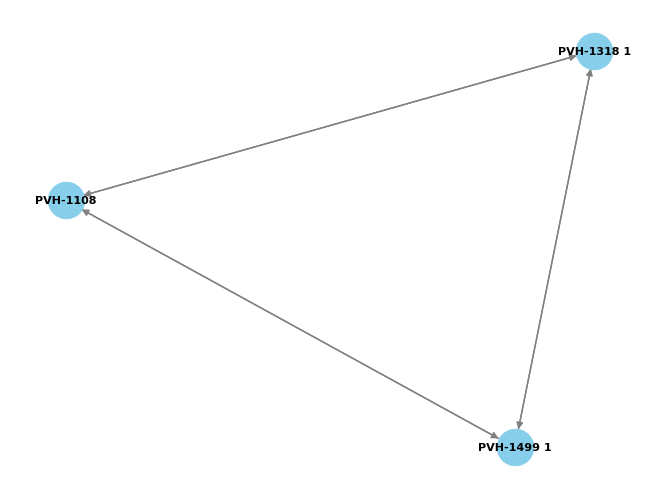

In [5]:
#%%
# Remove all connections (edges) from the graph
G.clear_edges()
# Connect nodes within 200 meters
for node_i, data_i in G.nodes(data=True):
    for node_j, data_j in G.nodes(data=True):
        if node_i != node_j:  # Avoid self-loops
            distance = calculate_distance(data_i['latitude'], data_i['longitude'],
                                          data_j['latitude'], data_j['longitude'])
            if distance < 4: #3
                G.add_edge(node_i, node_j)

# Draw the graph
plt.figure()
# pos = nx.get_node_attributes(G, 'pos')
pos = nx.spring_layout(G)
nx.draw(G, pos, with_labels=True, node_size=700, node_color='skyblue',
        font_size=8, font_color='black', font_weight='bold',
        arrowsize=10, edge_color='gray', linewidths=0.5)

#plt.title('Grid Layout with Connections within 200m')
plt.show()

Importar datos de registros del pozos conocido, en este caso, el 1318. Esta informacion se registra en un dataframe llamado "tops"

In [15]:
ruta_archivo = ruta_logs +"/Capas O PVH-1318_PVH-1499.xls"

# Leer el archivo usando pandas
tops = pd.read_excel(ruta_archivo)
tops=tops[tops["Pozo"]=="PVH-1318"]
a = tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Tope"]]
a.rename(columns={"Tope": "Ref"}, inplace=True)

b=tops.loc[tops["Pozo"] == "PVH-1318", ["Pozo", "Capa", "Base"]]
b.rename(columns={"Base": "Ref"}, inplace=True)
resultado = pd.concat([a, b], ignore_index=True)
tops=resultado
# Mostrar las primeras filas del DataFrame para verificar la lectura
print(tops.head(10))


plt.show()

tops = tops.sort_values(by='Ref', ascending=True).reset_index()
G.nodes['PVH-1318 1']["tops"]=tops

       Pozo  Capa        Ref
0  PVH-1318   O4T  1600.6632
1  PVH-1318   O5T  1614.4039
2  PVH-1318  O5aT  1624.3099
3  PVH-1318  O5bT  1630.0619
4  PVH-1318   O7T  1639.0092
5  PVH-1318   O4T  1610.2498
6  PVH-1318   O5T  1619.7299
7  PVH-1318  O5aT  1626.8663
8  PVH-1318  O5bT  1633.5769
9  PVH-1318   O7T  1642.5242


Importar la data de tops del pozp 1499. Esto se usa despues para evaluar el algoritmo. Estos datos se registran en un dataframe llamado "vtops"

In [16]:

vtops = pd.read_excel(ruta_archivo)
vtops=vtops[vtops["Pozo"]=="PVH-1499"]
a = vtops.loc[vtops["Pozo"] == "PVH-1499", ["Pozo", "Capa", "Tope"]]
a.rename(columns={"Tope": "Ref"}, inplace=True)

b=vtops.loc[vtops["Pozo"] == "PVH-1499", ["Pozo", "Capa", "Base"]]
b.rename(columns={"Base": "Ref"}, inplace=True)
resultado = pd.concat([a, b], ignore_index=True)
vtops=resultado
# Mostrar las primeras filas del DataFrame para verificar la lectura
print(vtops.head(10))


plt.show()

       Pozo  Capa        Ref
0  PVH-1499   O4T  1592.4712
1  PVH-1499   O5T  1606.4203
2  PVH-1499  O5aT  1616.9452
3  PVH-1499  O5bT  1622.1523
4  PVH-1499   O7T  1629.9545
5  PVH-1499   O4T  1601.8442
6  PVH-1499   O5T  1611.4777
7  PVH-1499  O5aT  1620.5903
8  PVH-1499  O5bT  1625.8013
9  PVH-1499   O7T  1634.1488


Esto es el algoritmo principal. *dtw_calc* hace la computacion principal. *calc_tops* actualiza los datos de tops del siguiente nodo. *profiles_comparison* crea un grafico del dtw path

In [21]:

# helper methods
def normalize_array(arr):
    reshaped_arr = arr.reshape(-1, 1)
    scaler = MinMaxScaler()
    normalized_arr = scaler.fit_transform(reshaped_arr)
    return normalized_arr

def custom_distance(p1, p2):
    return np.abs(p1 - p2) **(1/ 4.1)



# node 1 is the curernt node
# node 2 is the node you attempt to move to
# function gets a dataframe with the predicted depths, assigns to "tops" label in node
def calc_tops(G, node1, node2):
    
    correla, df1, df2 = dtw_calc(G, node1, node2)

    # create a list of j values for unique i values
    df_result = pd.DataFrame(columns=["Capa",'Ref'])
    j_values_dict = {}
    for i, j in correla:
        
        if i not in j_values_dict:
            j_values_dict[i] = []
        j_values_dict[i].append(j)

    rows_to_add = []
    # obtaining a 1 to 1 relationship between i and j by averaging 
    for i, j_values in j_values_dict.items():
        i_depth = df1["DEPTH"].iloc[i]
        j_depths = [df2["DEPTH"].iloc[j] for j in j_values]
        # averaging j values
        j_depth = np.mean(j_depths)
        #print(f'i = {i_depth}, j = {j_depth}')
        rows_to_add.append({'Ref': j_depth})
    capas = ["O4T", "O4T", "O5T", "O5T", "O5aT", "O5aT", "O5bT", "O5bT", "O7T", "O7T", ]
    df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)
    df_result["Capa"] = capas

    # assign new top values to the node
    G.nodes[node2]["tops"]=df_result
    #print(G.nodes[node2]["tops"])


def dtw_calc(G, node1, node2, tol=None):
    if tol:
        tolerance = tol
    else:
        tolerance = 0.05

        
    df1 = G.nodes[node1]["data"] # RES_DEEP data for node1
    tops = G.nodes[node1]["tops"] # Tops data for node1

    df2 = G.nodes[node2]["data"] # RES_DEEP data for node2



    # mark rows within the tolerance range of any top
    for index_df1, row_df1 in df1.iterrows():
        depth_value = row_df1['DEPTH']
        matches = tops['Ref'].apply(lambda x: np.abs(x - depth_value) <= tolerance)
        if matches.any():
            df1.at[index_df1, 'Present'] = 1

    G.nodes[node1]["is_top"] = df1[df1['Present'] == 1] # store the filtered rows near the topes into the graph
    prof1 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"][0] - 50
    prof2 = df1[df1['Present'] == 1]["DEPTH"].reset_index()["DEPTH"].iloc[-1] + 50
    df1 = df1[(df1['DEPTH'] > prof1) & (df1['DEPTH'] < prof2)].reset_index()
    df2 = df2[(df2['DEPTH'] > prof1) & (df2['DEPTH'] < prof2)].reset_index()


    # normalize res deep in df1 and df2
    w1 = np.array(df1['RES_DEEP'].dropna())
    w2 = np.array(df2['RES_DEEP'].dropna())
    # might need to use normalized values later, not rn tho
    w1_normalized = normalize_array(w1)
    w2_normalized = normalize_array(w2)


    ref = df1[df1["Present"] == 1]
    distance, path = fastdtw(w1, w2, dist=custom_distance)
    # distance, path = fastdtw(w1_normalized, w2_normalized, dist=custom_distance) Might need to normalize later
    correla = [tupla for tupla in path if tupla[0] in ref.index]

    #mark tops in df2, this block of code is not necessary
    # correla2 = [tupla[1] for tupla in correla]
    # df2["is_top"] = 0
    # for elemento in correla2:
    #     if elemento in df2.index:
    #         df2.loc[elemento, "is_top"] = 1
    # G.nodes[node2]["is_top"] = df2[df2["is_top"] == 1]
    # G.nodes[node2]["Procesados"] = df2
    
    return correla, df1, df2


def profiles_comparison(G, node1, node2):
    correla, df1, df2 = dtw_calc(G, node1, node2)

    offset = 50
    plt.figure(figsize=(10, 6))

    # Plot df1
    plt.plot(df1["DEPTH"], df1["RES_DEEP"], label=node1, color='blue')

    # Plot df2 with offset
    plt.plot(df2["DEPTH"], df2["RES_DEEP"] + offset, label=node2, color='orange')

    for i, j in correla:
        # Plot the DTW path
        plt.plot([df1["DEPTH"].iloc[i], df2["DEPTH"].iloc[j]], [df1["RES_DEEP"].iloc[i], df2["RES_DEEP"].iloc[j] + offset], color='red', linestyle='-')

    plt.title(node2 + " " + node1)
    plt.xlabel('Depth (m)')
    plt.ylabel('Valor')
    plt.legend()
    plt.grid(True)
    plt.show()

def calc_series(G, nodes_list, tolerance=None, distance_calc=None):
    num_nodes = len(nodes_list)-1
    node1 = G.nodes[nodes_list[0]]

    caps_data = pd.DataFrame({
        'Capa': node1["tops"]["Capa"],
        f'{nodes_list[0]}': node1["tops"]["Ref"]
    })
    
    for i in range(0,num_nodes):
        curr = G.nodes[nodes_list[i+1]]
        calc_tops(G, nodes_list[i], nodes_list[i+1])
        caps_data[nodes_list[i+1]] = curr["tops"]["Ref"]
        caps_data.insert

    print(caps_data)

In [22]:
test_series = ["PVH-1318 1", "PVH-1499 1"]
calc_series(G, test_series)

   Capa  PVH-1318 1  PVH-1499 1
0   O4T   1600.6632   1591.5332
1   O4T   1610.2498   1601.6332
2   O5T   1614.4039   1606.3332
3   O5T   1619.7299   1611.5332
4  O5aT   1624.3099   1616.5332
5  O5aT   1626.8663   1619.4832
6  O5bT   1630.0619   1622.4332
7  O5bT   1633.5769   1625.9332
8   O7T   1639.0092   1629.9332
9   O7T   1642.5242   1632.9332


C:\Users\User\AppData\Local\Temp\ipykernel_17480\636614823.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


Aqui se corre el algoritmo, calculando los topes de 1499 usando los datos de 1318

C:\Users\User\AppData\Local\Temp\ipykernel_19992\1066976024.py:39: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_result = pd.concat([df_result, pd.DataFrame(rows_to_add)], ignore_index=True)


   Capa        Ref
0   O4T  1591.5332
1   O4T  1601.6332
2   O5T  1606.3332
3   O5T  1611.5332
4  O5aT  1616.5332
5  O5aT  1619.4832
6  O5bT  1622.4332
7  O5bT  1625.9332
8   O7T  1629.9332
9   O7T  1632.9332


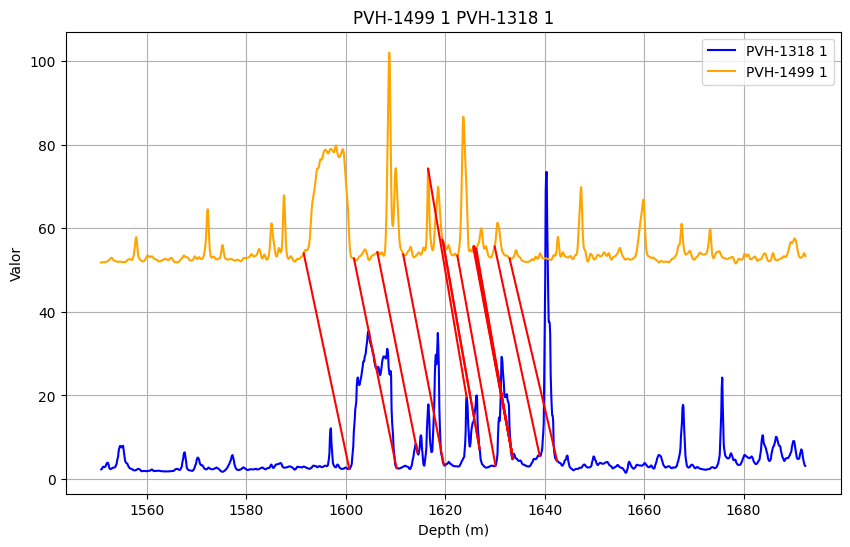

In [229]:
calc_tops(G, "PVH-1318 1", "PVH-1499 1")
profiles_comparison(G, "PVH-1318 1", "PVH-1499 1")

Como los valores de 1499 son conocidos, usamos esos datos para evaluar el algoritmo

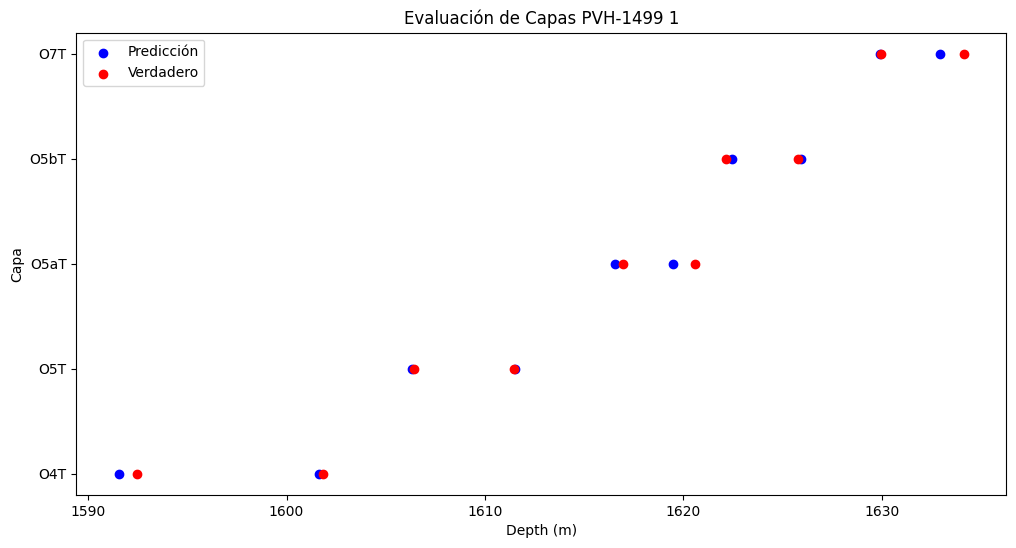

In [230]:
df_topes = G.nodes["PVH-1499 1"]["tops"]

plt.figure(figsize=(12, 6))
plt.scatter(df_topes['Ref'], df_topes['Capa'], color='blue', label='Predicción')
plt.scatter(vtops['Ref'], vtops['Capa'], color='red', label='Verdadero')

plt.xlabel('Depth (m)')
plt.ylabel('Capa')
plt.title('Evaluación de Capas PVH-1499 1')
plt.legend()
plt.show()

Mas analisis

  Capa_x   Ref_pred   Ref_true      Pozo Capa_y
0    O4T  1591.5332  1592.4712  PVH-1499    O4T
1    O4T  1601.6332  1601.8442  PVH-1499    O4T
2    O5T  1606.3332  1606.4203  PVH-1499    O5T
3    O5T  1611.5332  1611.4777  PVH-1499    O5T
4   O5aT  1616.5332  1616.9452  PVH-1499   O5aT
5   O5aT  1619.4832  1620.5903  PVH-1499   O5aT
6   O5bT  1622.4332  1622.1523  PVH-1499   O5bT
7   O5bT  1625.9332  1625.8013  PVH-1499   O5bT
8    O7T  1629.9332  1629.9545  PVH-1499    O7T
9    O7T  1632.9332  1634.1488  PVH-1499    O7T


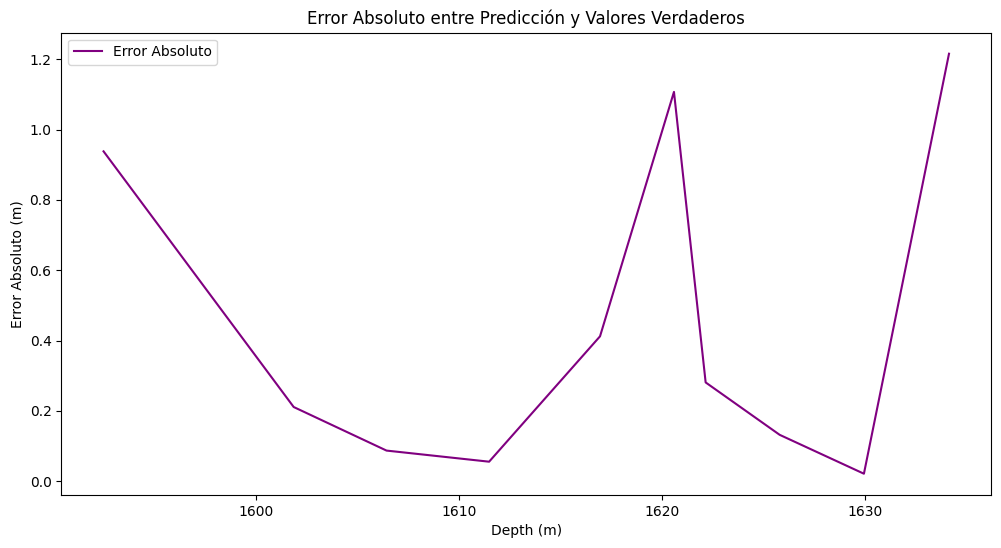

In [231]:
# Calcular la diferencia absoluta entre las predicciones y los valores verdaderos
vtops_sorted = vtops.sort_values(by='Ref', ascending=True).reset_index() # sort to get the depths in order

df_merged = pd.merge_asof(df_topes.sort_values('Ref'), vtops.sort_values('Ref'), on='Ref', direction='nearest')
df_merged.rename(columns={"Ref": "Ref_pred"}, inplace=True)
df_merged.insert(2, "Ref_true", vtops_sorted['Ref'])
print(df_merged)


df_merged['Error_Absoluto'] = np.abs(df_merged['Ref_pred'] - df_merged['Ref_true'])
df_merged['Error_Porcentual'] = df_merged['Error_Absoluto'] / df_merged['Ref_true'] * 100

# Resumen estadístico
estadisticas = df_merged[['Error_Absoluto', 'Error_Porcentual']].describe()


# Gráfico de errores absolutos
plt.figure(figsize=(12, 6))
plt.plot(df_merged['Ref_true'], df_merged['Error_Absoluto'], label='Error Absoluto', color='purple')
plt.xlabel('Depth (m)')
plt.ylabel('Error Absoluto (m)')
plt.title('Error Absoluto entre Predicción y Valores Verdaderos')
plt.legend()
plt.show()
